## 🎬 Netflix Dataset EDA

This notebook explores the **Netflix Movies and TV Shows dataset** to uncover insights about content trends, genres, countries, and release patterns.  
The analysis includes:

- Data cleaning and preparation  
- Distribution of Movies vs TV Shows  
- Most common genres, directors, and actors  
- Trends over time (release year vs date added)   
- Duration analysis for Movies and TV Shows  
- Text analysis of show descriptions  

The goal is to **understand how Netflix’s catalog has evolved** and highlight interesting patterns in its global content.


### Setup & Data Import

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter

from wordcloud import WordCloud, STOPWORDS
import re

# Load dataset
df = pd.read_csv("data/netflix_data.csv")

# Quick overview
print(df.shape)
print(df.info())
df.head()

(4812, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       4812 non-null   object
 1   type          4812 non-null   object
 2   title         4812 non-null   object
 3   director      4812 non-null   object
 4   cast          4812 non-null   object
 5   country       4812 non-null   object
 6   date_added    4812 non-null   object
 7   release_year  4812 non-null   int64 
 8   duration      4812 non-null   int64 
 9   description   4812 non-null   object
 10  genre         4812 non-null   object
dtypes: int64(2), object(9)
memory usage: 413.7+ KB
None


,show_id,type,title,director,cast,country,date_added,release_year,duration,description,genre
0,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,93,After a devastating earthquake hits Mexico Cit...,Dramas
1,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,78,"When an army recruit is found dead, his fellow...",Horror Movies
2,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,80,"In a postapocalyptic world, rag-doll robots hi...",Action
3,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,123,A brilliant group of students become card-coun...,Dramas
4,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016,1,A genetics professor experiments with a treatm...,International TV


### Data Cleaning
The dataset has been checked and cleaned to ensure it is ready for analysis:

- **No missing values** were found across the dataset.  
- **No duplicate rows** were detected.
- **`date_added`** has been converted to datetime format for easier time-based analysis.

In [155]:
# Missing values
print('Missing values')
print(df.isnull().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert date
df['date_added'] = pd.to_datetime(df['date_added'].str.strip())

Missing values
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
duration        0
description     0
genre           0
dtype: int64


### Basic Descriptive Analysis

To build an overall understanding of the dataset, we start with some **descriptive statistics and visual exploration**.  
This step highlights the general structure of Netflix’s catalog and helps identify patterns worth deeper analysis later.

- Number of Movies vs TV Shows  
- Most Common Countries
- Most Frequent Genres
- Top Directors  
- Distribution of Release Years 

#### Movies vs TV Shows
 - Compare the total number of Movies and TV Shows available.  
 - Identify whether Netflix’s library is more film-focused or series-focused.

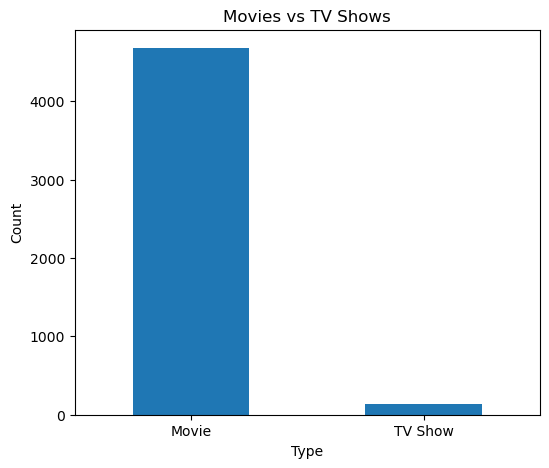

In [156]:
# Type split
plt.figure(figsize=(6, 5))
df['type'].value_counts().plot(kind='bar', title="Movies vs TV Shows")
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Type')
plt.show()

#### Country Distribution
- Find out which countries contribute the most titles.  
- Spot regional differences in content production.  

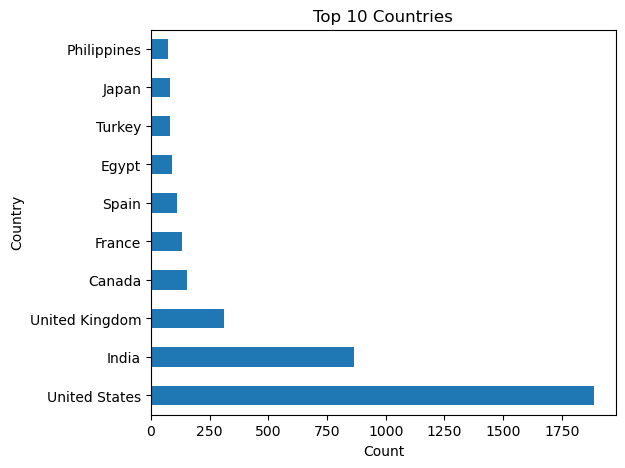

In [157]:
# --- Top countries ---

plt.figure(figsize=(6, 5))
df['country'].value_counts().head(10).plot(kind='barh', title="Top 10 Countries")
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

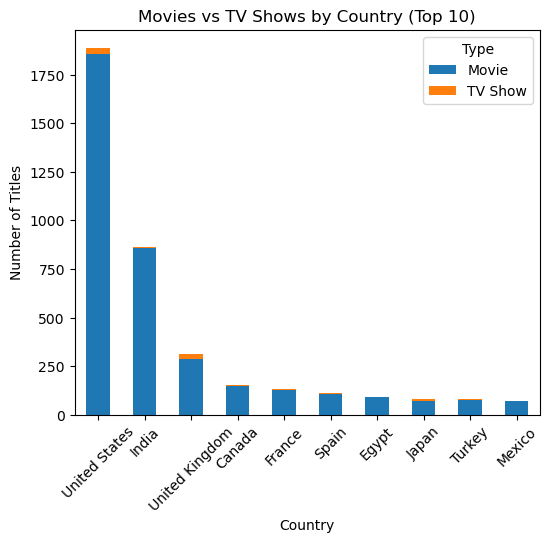

In [158]:
# Count by country & type
country_type = df.groupby(['country','type']).size().unstack().fillna(0)

# Take top 10 countries by total number of titles
top_countries_type = country_type.sum(axis=1).sort_values(ascending=False).head(10)
country_type_top = country_type.loc[top_countries_type.index]

# Plot stacked bar chart
country_type_top.plot(kind='bar', stacked=True, figsize=(6,5))
plt.title("Movies vs TV Shows by Country (Top 10)")
plt.xlabel("Country")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.legend(title="Type")
plt.show()


#### Genre Popularity
- Explore the most frequent genres across Netflix.  
- Identify dominant themes such as Drama, Comedy, Documentary, etc. 


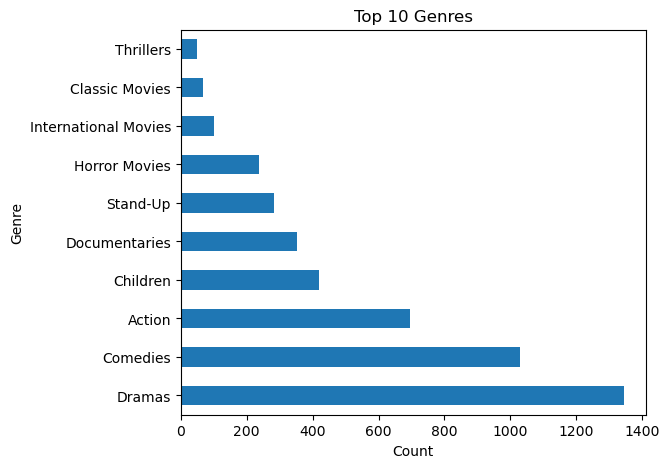

In [159]:
# --- Top genres ---

plt.figure(figsize=(6, 5))
df['genre'].value_counts().head(10).plot(kind='barh', title="Top 10 Genres")
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

#### Directors and Cast
- Explore the most frequent genres across Netflix.  
- Identify dominant themes such as Drama, Comedy, Documentary, etc. 

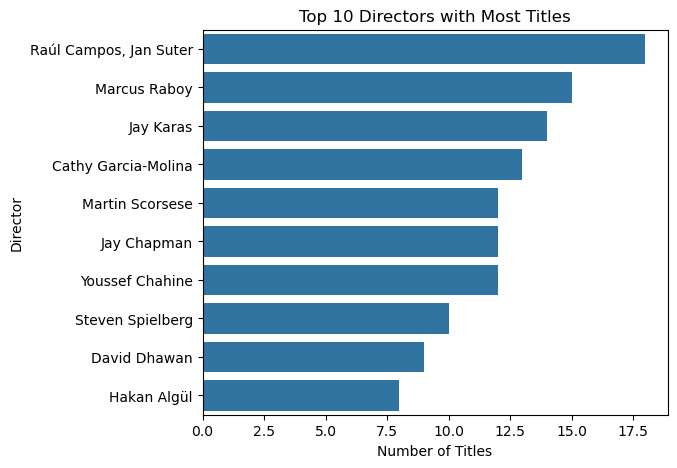

In [160]:
# --- Top 10 directors ---

top_directors = df['director'].value_counts().head(10)

plt.figure(figsize=(6,5))
sns.barplot(y=top_directors.index, x=top_directors.values)
plt.title("Top 10 Directors with Most Titles")
plt.xlabel("Number of Titles")
plt.ylabel("Director")
plt.show()

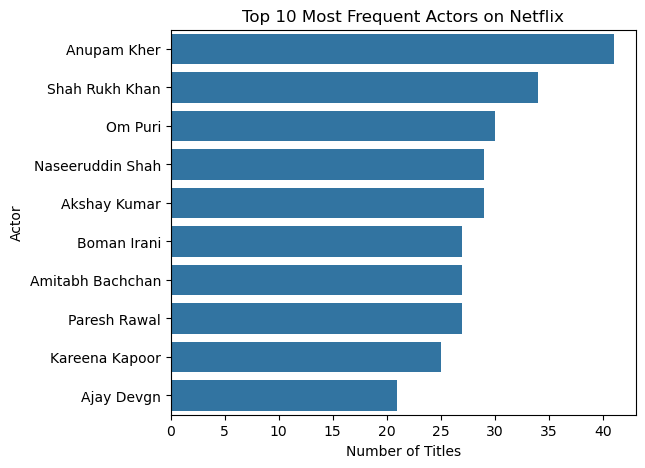

In [161]:
# --- Top 10 directors ---

# Drop missing values, split cast by comma, flatten into a single list
cast_list = df['cast'].dropna().apply(lambda x: [i.strip() for i in x.split(',')])
all_actors = [actor for sublist in cast_list for actor in sublist]

# Count top 10 actors
actor_counts = Counter(all_actors).most_common(10)

# Convert to DataFrame for plotting
actor_df = pd.DataFrame(actor_counts, columns=['Actor', 'Count'])

plt.figure(figsize=(6,5))
sns.barplot(y='Actor', x='Count', data=actor_df)
plt.title("Top 10 Most Frequent Actors on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Actor")
plt.show()


#### Distribution of Release Years
- Analyse how the number of releases changes across years.  
- Detect peaks or declines in content production trends.  

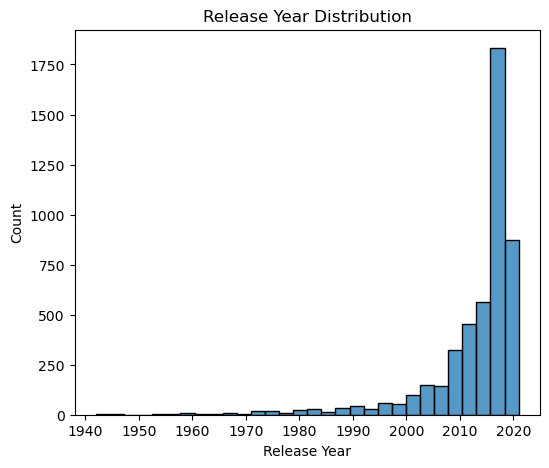

In [162]:
# --- Release year distribution ---

plt.figure(figsize=(6, 5))
sns.histplot(df['release_year'].dropna(), bins=30, kde=False)
plt.title("Release Year Distribution")
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

### Time-based Analysis
Understanding how Netflix’s catalog has evolved over time provides insights into the platform’s growth strategy and content acquisition patterns.  

- Titles Added Per Year
- Release Year vs Date Added
- Growth of the Netflix Catalog

#### Titles Added Per Year
- Track how many titles were added to Netflix each year.  
- Helps identify the years of fastest catalog growth.  

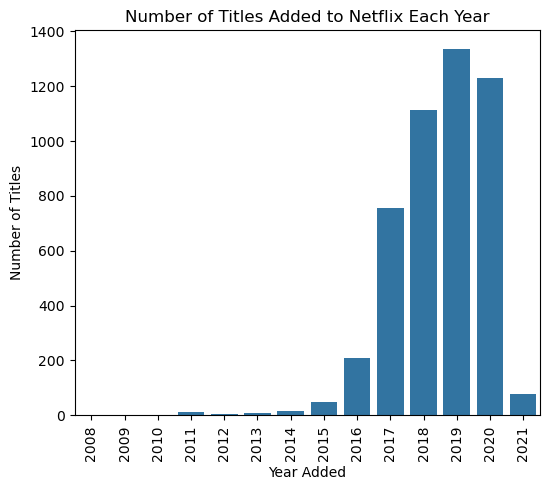

In [163]:
# --- Titles added to Netflix per year ---

df['year_added'] = df['date_added'].dt.year

plt.figure(figsize=(6,5))
sns.countplot(x='year_added', data=df, order=sorted(df['year_added'].dropna().unique()))
plt.xticks(rotation=90)
plt.title("Number of Titles Added to Netflix Each Year")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.show()

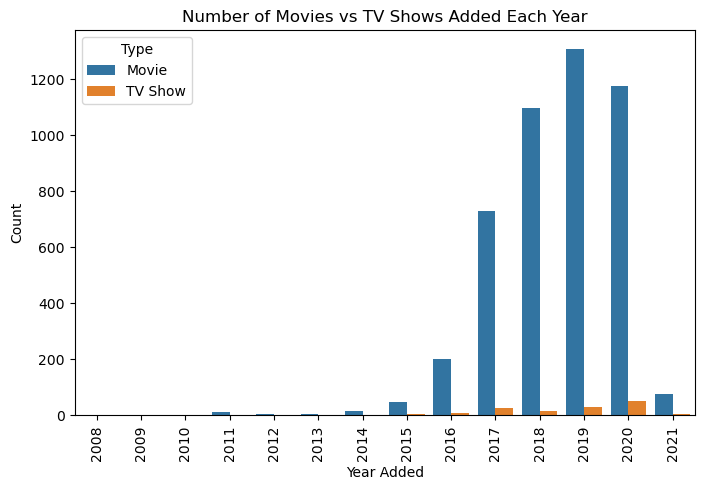

In [164]:
# --- Movies vs Shows added to Netflix per year ---

plt.figure(figsize=(8,5))
sns.countplot(x='year_added', hue='type', data=df, order=sorted(df['year_added'].dropna().unique()))
plt.xticks(rotation=90)
plt.title("Number of Movies vs TV Shows Added Each Year")
plt.xlabel("Year Added")
plt.ylabel("Count")
plt.legend(title="Type")
plt.show()

#### Release Year vs Date Added
 - Compare when a title was originally released with the year it was added to Netflix.  
 - This shows whether Netflix focuses more on **new releases** or on acquiring **older content**.  


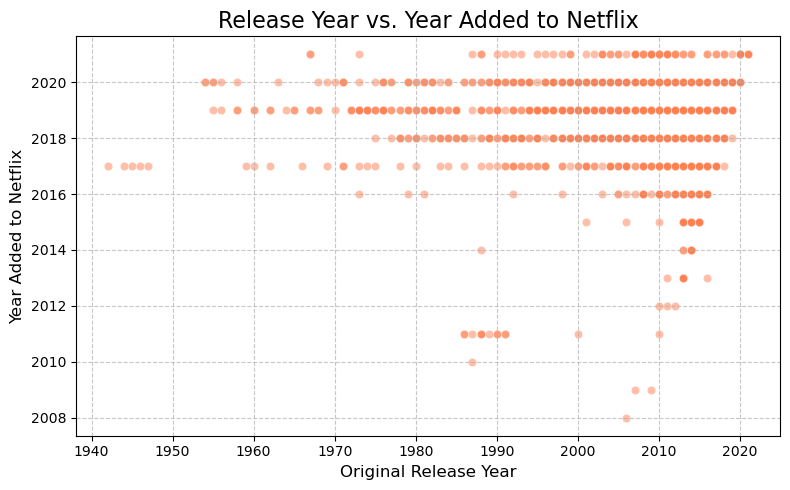

In [165]:
# --- Compare release year vs. date added ---

# Plot to visualise the relationship between release year and when the title was added.
# This plot can reveal trends like older movies being added more recently.
plt.figure(figsize=(8, 5))
sns.scatterplot(x='release_year', y='year_added', data=df, alpha=0.5, color='coral')
plt.title('Release Year vs. Year Added to Netflix', fontsize=16)
plt.xlabel('Original Release Year', fontsize=12)
plt.ylabel('Year Added to Netflix', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Growth of the Netflix Catalog
- Measure the cumulative number of titles available over time.  
- Reveals how quickly Netflix expanded its library and if growth is slowing down or accelerating in recent years.  

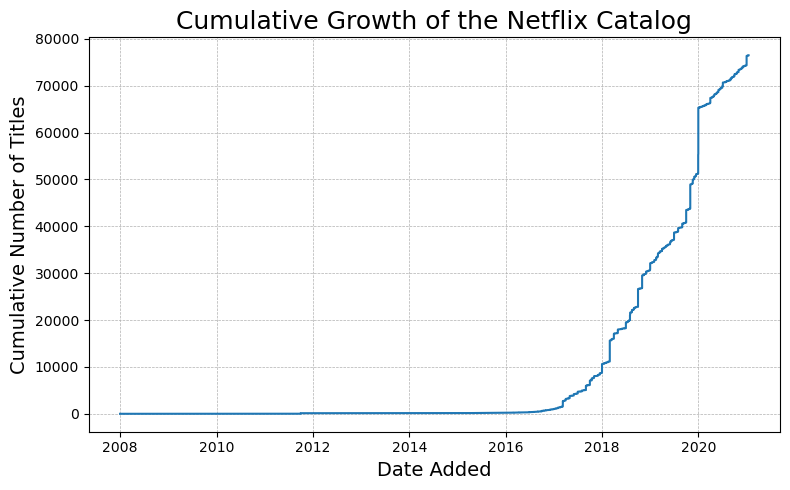

In [166]:
# Sort the DataFrame by the date added. This is essential for a correct cumulative sum.
df.sort_values('date_added', inplace=True)

# Calculate the cumulative count of titles over time.
# We first group by the date and count the number of titles added each day.
# Then, we apply the cumsum() function to get the running total.
df['cumulative_titles'] = df.groupby('date_added')['show_id'].transform('count').cumsum()

# Create the line plot.
plt.figure(figsize=(8, 5))
plt.plot(df['date_added'], df['cumulative_titles'], marker='', linestyle='-')
plt.title('Cumulative Growth of the Netflix Catalog', fontsize=18)
plt.xlabel('Date Added', fontsize=14)
plt.ylabel('Cumulative Number of Titles', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Duration & Format Insights
Analysing the length of Movies and the number of seasons of TV Shows provides insights into how Netflix structures its content.  
Some content may be unusually short (e.g., short films) or unusually long (e.g., extended specials or multi-season series).  

- Distribution of Movie Durations
- TV Show Seasons

#### Distribution of Movie Durations
  - Explore how long most Netflix movies are.  
  - Identify typical ranges (e.g., 90–120 minutes is common for feature films).  
  - Detect outliers such as unusually short or long movies.   

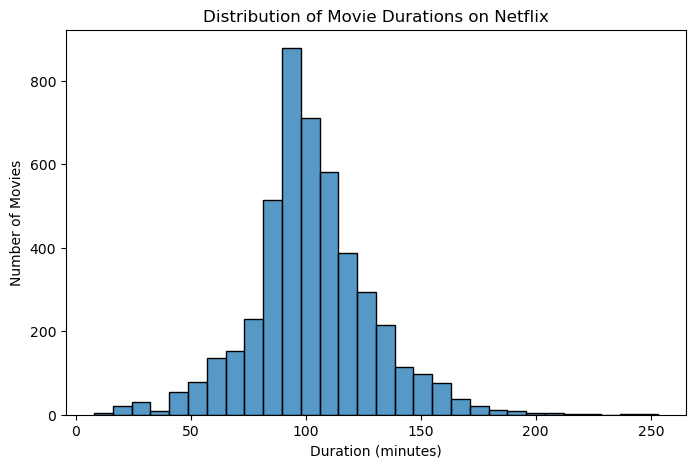

Average movie duration: 102.38
Median movie duration: 100.0
Shortest movie: 8 minutes
Longest movie: 253 minutes


In [167]:
# Movie durations
movies = df[df['type'] == "Movie"]

plt.figure(figsize=(8,5))
sns.histplot(movies['duration'].dropna(), bins=30, kde=False)
plt.title("Distribution of Movie Durations on Netflix")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Movies")
plt.show()


# Quick summary statistics
print("Average movie duration:", np.round(movies['duration'].mean(), 2))
print("Median movie duration:", movies['duration'].median())
print("Shortest movie:", movies['duration'].min(), "minutes")
print("Longest movie:", movies['duration'].max(), "minutes")

#### TV Show Seasons

- Examine how many seasons most TV Shows have.  
- Identify whether Netflix favors limited series (1–2 seasons) or longer-running shows.  

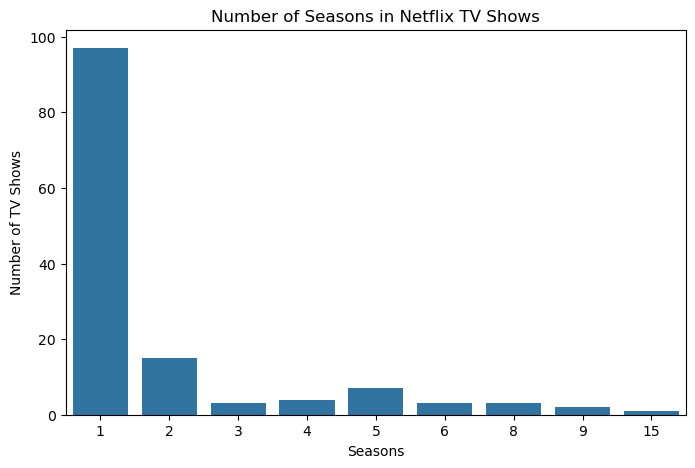

Average number of seasons: 1.94
Most common number of seasons: 1
Longest running show: 15 seasons


In [168]:
# Filter TV Shows
tv_shows = df[df['type'] == "TV Show"]

plt.figure(figsize=(8,5))
sns.countplot(x='duration', data=tv_shows, order=sorted(tv_shows['duration'].dropna().unique()))
plt.title("Number of Seasons in Netflix TV Shows")
plt.xlabel("Seasons")
plt.ylabel("Number of TV Shows")
plt.show()


# Quick summary statistics
print("Average number of seasons:", np.round(tv_shows['duration'].mean(), 2))
print("Most common number of seasons:", tv_shows['duration'].mode()[0])
print("Longest running show:", tv_shows['duration'].max(), "seasons")

In [169]:
# Top 10 longest-running TV Shows
top_tv_shows = tv_shows[['title', 'duration']].sort_values(by="duration", ascending=False).head(10)
top_tv_shows

,title,duration
3678,Supernatural,15
2758,Naruto,9
783,Call the Midwife,9
3996,The Great British Baking Show,8
3292,Royal Pains,8
403,Arrow,8
1339,Father Brown,6
3962,The Flash,6
945,Comedians in Cars Getting Coffee,6
2523,Men on a Mission,5


### Text Analysis of Show Descriptions
The `description` column contains short text summaries of each show.  
By analysing this text, we can discover common themes, genres, and patterns in Netflix’s catalog. 

- Word cloud of show descriptions
- Keyword frequency

#### Word Cloud of Descriptions
- Visualise the most common words across all show descriptions.  
- Helps spot recurring themes (e.g., "love", "family", "murder", "friendship").  

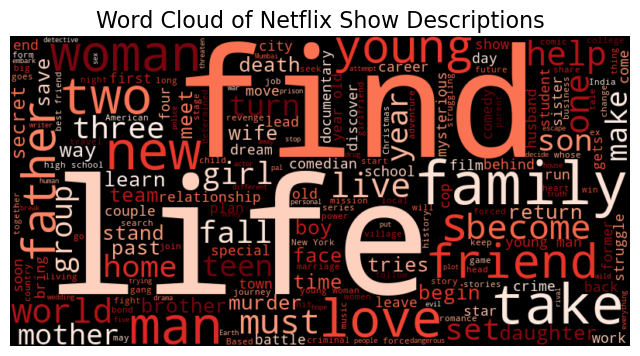

In [170]:

# Combine all descriptions into one string
text = " ".join(df['description'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='black',
    stopwords=set(STOPWORDS),
    colormap='Reds'
).generate(text)

# Plot
plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Netflix Show Descriptions", fontsize=16)
plt.show()

#### Keyword Frequency
  - Count and rank the most frequent words.  
  - Identify dominant topics and genre-related terms in Netflix’s catalog.  

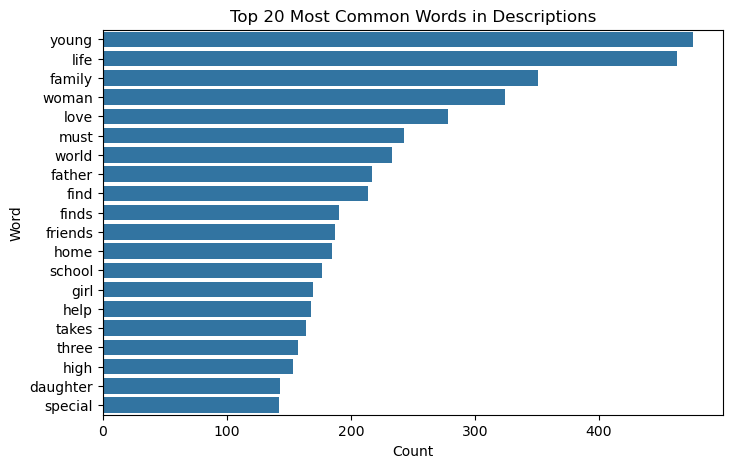

In [171]:
text = " ".join(df['description'].dropna().astype(str))

# Tokenize and clean text
words = re.findall(r'\w+', text.lower())  # split into words
stopwords = set(STOPWORDS)
filtered_words = [w for w in words if w not in stopwords and len(w) > 3]

# Count frequencies
word_freq = Counter(filtered_words).most_common(20)

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(word_freq, columns=['word', 'count'])

plt.figure(figsize=(8,5))
sns.barplot(y='word', x='count', data=word_freq_df)
plt.title("Top 20 Most Common Words in Descriptions")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()